In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import cv2                         # To read and manipulate images
import matplotlib.pyplot as plt    # Python 2D plotting library
%matplotlib inline  
from sklearn.preprocessing import LabelEncoder
import torch
import torchvision

In [2]:
TRAIN_PATH = 'data/CAX_Superhero_Train/'
TEST_PATH = 'data/CAX_Superhero_Test/'
superhero_dic = {'Ant-Man':'ant_man', 'Aquaman':'aqua_man', 'Avengers':'avengers', 'Batman':'bat_man', 
                 'Black Panther':'black_panther', 'Captain America':'captain_america', 'Catwoman':'cat_woman',
                 'Ghost Rider':'ghostrider', 'Hulk':'hulk', 'Iron Man':'iron_man', 'Spiderman':'spider_man', 
                 'Superman':'super_man'}

IMG_HEIGHT = 260
IMG_WIDTH = 200

In [7]:
test_ids = next(os.walk(TEST_PATH))

In [9]:
TRAIN_PATH_Ant = 'data/CAX_Superhero_Train/Ant-Man'

In [10]:
train_ant = next(os.walk(TRAIN_PATH_Ant))

In [17]:
len(train_ant[2])

241

In [19]:
train = next(os.walk(TRAIN_PATH))

In [25]:
train

('data/CAX_Superhero_Train/',
 ['Ant-Man',
  'Aquaman',
  'Avengers',
  'Batman',
  'Black Panther',
  'Captain America',
  'Catwoman',
  'Ghost Rider',
  'Hulk',
  'Iron Man',
  'Spiderman',
  'Superman'],
 [])

In [3]:
os.getcwd()  

'D:\\Андрей\\Cloud Mail.Ru\\ML\\Competitions\\Identifying Superheroes from Product Images'

In [ ]:
CW_DIR = os.getcwd()  
TRAIN_DIR = os.path.join(os.path.dirname(CW_DIR), 'input', 'stage1_train')
TRAIN_DIR = 'data/CAX_Superhero_Train/'
TEST_DIR = os.path.join(os.path.dirname(CW_DIR), 'input', 'stage1_test')
IMG_TYPE = '.png'         # Image type
IMG_DIR_NAME = 'images'   # Folder name including the image
MASK_DIR_NAME = 'masks'   # Folder name including the masks
LOGS_DIR_NAME = 'logs'    # Folder name for TensorBoard summaries 
SAVES_DIR_NAME = 'saves'  # Folder name for storing network parameters
SEED = 123                # Random seed for splitting train/validation sets

In [4]:
train_dir = 'data/CAX_Superhero_Train/'

In [58]:
next(os.walk(TRAIN_PATH))[1]

['Ant-Man',
 'Aquaman',
 'Avengers',
 'Batman',
 'Black Panther',
 'Captain America',
 'Catwoman',
 'Ghost Rider',
 'Hulk',
 'Iron Man',
 'Spiderman',
 'Superman']

In [68]:
sample_submission = pd.read_csv('data/Sample_Submission_Values.csv')
sample_submission['Superhero']

0             ant_man
1           super_man
2            iron_man
3             bat_man
4     captain_america
5          spider_man
6                hulk
7            avengers
8       black_panther
9           cat_woman
10           aqua_man
11         ghostrider
Name: Superhero, dtype: object

In [69]:
superhero_dic = {'Ant-Man':'ant_man', 'Aquaman':'aqua_man', 'Avengers':'avengers', 'Batman':'bat_man', 
                 'Black Panther':'black_panther', 'Captain America':'captain_america', 'Catwoman':'cat_woman',
                 'Ghost Rider':'ghostrider', 'Hulk':'hulk', 'Iron Man':'iron_man', 'Spiderman':'spider_man', 
                 'Superman':'super_man'}

In [70]:
superhero_dic

{'Ant-Man': 'ant_man',
 'Aquaman': 'aqua_man',
 'Avengers': 'avengers',
 'Batman': 'bat_man',
 'Black Panther': 'black_panther',
 'Captain America': 'captain_america',
 'Catwoman': 'cat_woman',
 'Ghost Rider': 'ghostrider',
 'Hulk': 'hulk',
 'Iron Man': 'iron_man',
 'Spiderman': 'spider_man',
 'Superman': 'super_man'}

In [67]:
superhero_dic = {}
for i, superhero_dir in enumerate(next(os.walk(TRAIN_PATH))[1]):
    superhero_dic[superhero_dir] = sample_submission['Superhero'][i]
superhero_dic

{'Ant-Man': 'ant_man',
 'Aquaman': 'super_man',
 'Avengers': 'iron_man',
 'Batman': 'bat_man',
 'Black Panther': 'captain_america',
 'Captain America': 'spider_man',
 'Catwoman': 'hulk',
 'Ghost Rider': 'avengers',
 'Hulk': 'black_panther',
 'Iron Man': 'cat_woman',
 'Spiderman': 'aqua_man',
 'Superman': 'ghostrider'}

In [4]:
superhero_dic['Ant-Man']

'ant_man'

In [3]:
def read_image(filepath, color_mode=cv2.IMREAD_COLOR, target_size=None):
    """Read an image from a file and resize it"""
    img = cv2.imread(filepath, color_mode)
    if target_size: 
        img = cv2.resize(img, target_size, interpolation = cv2.INTER_AREA)
    return img

In [4]:
def read_train_data_properties(train_dir):
    """Read basic properties of training images"""
    tmp = []
    for i,dir_name in enumerate(next(os.walk(train_dir))[1]):
        img_dir = os.path.join(train_dir, dir_name)
        superhero_dir = next(os.walk(img_dir))[2]
        for j in range(len(superhero_dir)):
            img_name = superhero_dir[j]
            img_path = os.path.join(img_dir, img_name)
            img_shape = read_image(img_path).shape
            superhero = superhero_dic[dir_name]
            tmp.append([img_name, img_shape[0], img_shape[1], img_shape[0]/img_shape[1], img_shape[2], superhero, img_path])

    train_df = pd.DataFrame(tmp, columns = ['img_name','img_height', 'img_width',  'img_ratio', 'num_channels',
                                            'superhero', 'img_path'])
    return train_df

In [30]:
def read_test_data_properties(test_dir):
    """Read basic properties of test images"""
    tmp = []
    img_dir = next(os.walk(test_dir))[2]
    for i,img_name in enumerate(img_dir):
        img_path = os.path.join(test_dir, img_name)
        img_shape = read_image(img_path).shape
        tmp.append([img_name, img_shape[0], img_shape[1], img_shape[0]/img_shape[1], img_shape[2], img_path])

    test_df = pd.DataFrame(tmp, columns = ['img_name','img_height', 'img_width',  'img_ratio', 'num_channels', 'img_path'])
    return test_df

In [25]:
train_df['img_path'].loc[0]

'data/CAX_Superhero_Train/Ant-Man\\cax_antman_train1.jpg'

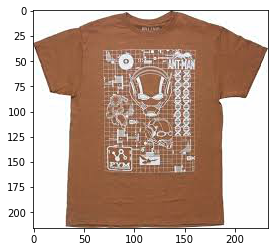

In [30]:
plt.imshow(read_image(train_df['img_path'].loc[0]))

In [ ]:
img = read_image(train_df['image_path'].loc[i], target_size=image_size)

In [31]:
# Basic properties of images/masks
train_df = read_train_data_properties(TRAIN_PATH)
print('train_df:')
print(train_df.describe())
test_df = read_test_data_properties(TEST_PATH)
print('test_df:')
print(test_df.describe())
print('')

train_df:
        img_height    img_width    img_ratio  num_channels
count  5433.000000  5433.000000  5433.000000        5433.0
mean    230.794773   197.981594     1.169293           3.0
std      37.450213    24.658881     0.162639           0.0
min     120.000000    73.000000     0.463636           3.0
25%     200.000000   190.000000     1.000000           3.0
50%     246.000000   200.000000     1.294737           3.0
75%     260.000000   200.000000     1.300000           3.0
max     522.000000   540.000000     3.561644           3.0
test_df:
        img_height    img_width    img_ratio  num_channels
count  3375.000000  3375.000000  3375.000000        3375.0
mean    233.944889   203.209185     1.159080           3.0
std      36.831582    31.001904     0.160660           0.0
min      80.000000    80.000000     0.561873           3.0
25%     200.000000   190.000000     1.000000           3.0
50%     246.000000   200.000000     1.294737           3.0
75%     260.000000   200.000000     1

In [7]:
train_df.head()

,img_name,img_height,img_width,img_ratio,num_channels,superhero,img_path
0,cax_antman_train1.jpg,216,233,0.927039,3,ant_man,data/CAX_Superhero_Train/Ant-Man\cax_antman_tr...
1,cax_antman_train10.jpg,230,210,1.095238,3,ant_man,data/CAX_Superhero_Train/Ant-Man\cax_antman_tr...
2,cax_antman_train100.jpg,225,225,1.000000,3,ant_man,data/CAX_Superhero_Train/Ant-Man\cax_antman_tr...
3,cax_antman_train101.jpg,251,201,1.248756,3,ant_man,data/CAX_Superhero_Train/Ant-Man\cax_antman_tr...
4,cax_antman_train102.jpg,225,225,1.000000,3,ant_man,data/CAX_Superhero_Train/Ant-Man\cax_antman_tr...


In [48]:
labelencoder = LabelEncoder()

In [55]:
heroes_label = labelencoder.fit_transform(heroes)
heroes_label

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

In [57]:
labelencoder.inverse_transform(heroes_label)

array(['ant_man', 'aqua_man', 'avengers', 'bat_man', 'black_panther',
       'captain_america', 'cat_woman', 'ghostrider', 'hulk', 'iron_man',
       'spider_man', 'super_man'], dtype=object)

In [10]:
# Counting unique train image shapes.
df = pd.DataFrame([[x] for x in zip(train_df['img_height'], train_df['img_width'])])
df[0].value_counts()[:10]

(260, 200)    1614
(246, 190)    1262
(180, 180)    1113
(200, 200)     600
(253, 253)     146
(225, 225)     140
(218, 218)      42
(400, 400)      21
(259, 194)      19
(480, 360)      18
Name: 0, dtype: int64

In [11]:
# Counting unique test image shapes.
df = pd.DataFrame([[x] for x in zip(test_df['img_height'], test_df['img_width'])])
df[0].value_counts()[:10]

(260, 200)    958
(246, 190)    729
(180, 180)    656
(253, 253)    263
(200, 200)    202
(225, 225)    123
(400, 400)     36
(218, 218)     27
(224, 224)     18
(260, 230)     17
Name: 0, dtype: int64

(120, 120, 3)

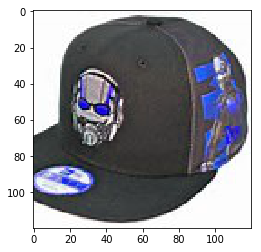

In [54]:
im = 'data/CAX_Superhero_Train/Ant-Man/cax_antman_train196.jpg'
plt.imshow(read_image(im))
read_image(im).shape

In [46]:
image_size=(1000, 500)

In [52]:
read_image(im, target_size=image_size).shape

(500, 500, 3)

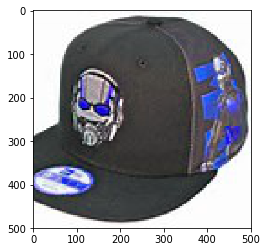

In [47]:
plt.imshow(read_image(im, target_size=image_size))

In [ ]:
cv2.resize(img, target_size, interpolation = cv2.INTER_AREA)

In [32]:
test_df.head()

,img_name,img_height,img_width,img_ratio,num_channels,img_path
0,superhero_test_1.jpg,246,190,1.294737,3,data/CAX_Superhero_Test/superhero_test_1.jpg
1,superhero_test_10.jpg,180,180,1.000000,3,data/CAX_Superhero_Test/superhero_test_10.jpg
2,superhero_test_100.jpg,253,253,1.000000,3,data/CAX_Superhero_Test/superhero_test_100.jpg
3,superhero_test_1000.jpg,246,190,1.294737,3,data/CAX_Superhero_Test/superhero_test_1000.jpg
4,superhero_test_1001.jpg,260,200,1.300000,3,data/CAX_Superhero_Test/superhero_test_1001.jpg


In [69]:
def load_raw_data(image_size=(IMG_HEIGHT, IMG_WIDTH)):
    """Load raw data."""
    # Python lists to store the training images/masks and test images.
    labelencoder = LabelEncoder()
    image_size=(IMG_HEIGHT, IMG_WIDTH)
    x_train, y_train, x_test = [],[],[]

    # Read and resize train images/superheroes. 
    print('Loading and resizing train images and labels ...')
    os.sys.stdout.flush()
    for i, filename in tqdm(enumerate(train_df['img_path']), total=len(train_df)):
        img = read_image(train_df['img_path'].loc[i], target_size=image_size)
        superhero = train_df['superhero'].loc[i] 
        x_train.append(img) 
        y_train.append(superhero)
        
    # Read and resize test images. 
    print('Loading and resizing test images ...')
    os.sys.stdout.flush()
    for i, filename in tqdm(enumerate(test_df['img_path']), total=len(test_df)):
        img = read_image(test_df['img_path'].loc[i], target_size=image_size)
        x_test.append(img)    
        
    # Transform lists into 4-dim numpy arrays (N,H,W,C)
    x_train = np.array(x_train)
    y_train = labelencoder.fit_transform(y_train)
    x_test = np.array(x_test)
    
    return x_train, y_train, x_test

In [70]:
# Read images/masks from files and resize them. Each image and mask 
# is stored as a 3-dim array where the number of channels is 3 and 1, respectively.
x_train, y_train, x_test = load_raw_data()

Loading and resizing train images and labels ...


100%|█████████████████████████████████████████████████████████████████████████████| 5433/5433 [00:07<00:00, 761.10it/s]


Loading and resizing test images ...


100%|█████████████████████████████████████████████████████████████████████████████| 3375/3375 [00:04<00:00, 744.36it/s]
